<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/shine-on-you/HomeWork2_Regression%26Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашняя работа 2

## Регрессия

С 1-ого октября отменяется НДС на бриллианты, теперь они становятся новым инвестиционным инструментом. Давайте сделаем модель ценообразования для них.

Скачайте датасет diamonds.csv

В нем представлены характеристики бриллиантов и их цены с сайта jamesallen (B2C площадка) с 2022-07-01

**Описание полей**


* fluor - флуорисценция (свойство камня светиться в ультрафиолетовых лучах)
* symmetry - показатель симметричности
* platform - название платформы, где был размещен камень
* quality_group - составной показатель из cut polish symmetry
* size_group - каратно весовая группа
* big_size_group - каратно-весовая группа
* shape - форма
* color - цвет
* clarity - чистота
* cut - качество огранки (может быть только у круглых камней)
* polish - полировка
* id - номер камня
* date - дата
* price - цена
* carat - кол-во карат
* tablepercent - размер площадки по отношению ширине
* price_per_carat - цена за карат
* z - длина (diameter)
* x - ширина
* depth_perc - отношение высоты к ширине
* y - высота



In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
#from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')
#path = 'drive/MyDrive/'

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Dimildizio/DS_course/main/shine-on-you/diamonds.csv', index_col=0)
df.shape

(222222, 17)

## EDA

In [5]:
df[df['date']==0]

,fluor,symmetry,platform,shape,color,clarity,cut,polish,id,date,price,carat,price_per_carat,z,x,depth_perc,y
202754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#print('number of duplicates:',df.duplicated(keep=False).sum() - df.shape[0])
#Удалим пусте значения (у них айди 0)
df1=df.copy()
df1=df1.drop(df1[df1.id == 0].index)
#поскольку у нас только одна платформа, нам этот параметр не нужен
df1=df1.drop('platform', axis = 1)
#заменим пустые значения в fluor для one-hot encoding. симметрия No
df1['fluor'].fillna('NONE', inplace=True)
#Удалим камни без огранки
df1.dropna(subset = ['cut'], inplace=True)
#Удалим полные дубли
df1 = df1.drop_duplicates()

In [7]:
#Для ускорения манипуляций с датасетом переведем все в более "легкие" типы данных
for col in ['fluor', 'symmetry','shape', 'clarity', 'color', 'cut','polish']:
  df1[col] = df1[col].astype('category')
for col in ['id','date']:
  df1[col] = df1[col].astype('int32')
for col in ['price', 'carat','price_per_carat', 'z', 'x', 'y', 'depth_perc']:
  df1[col] = df1[col].astype('float32')

<ipython-input-7-4d3919848ed3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col] = df1[col].astype('category')
<ipython-input-7-4d3919848ed3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col] = df1[col].astype('category')
<ipython-input-7-4d3919848ed3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [8]:
df1.describe().apply(lambda x: round(x,2))

,id,date,price,carat,price_per_carat,z,x,depth_perc,y
count,147594.00,147594.00,147594.00,147594.00,147594.00,147594.00,147594.00,147594.00,147594.00
mean,13649272.44,202206.03,11771.74,1.31,7492.82,6.68,6.65,63.98,4.24
std,2499814.34,0.82,24978.34,0.66,5388.50,0.91,0.93,4.03,0.53
min,19423.00,202205.00,920.00,0.81,1135.80,4.84,4.52,56.00,2.84
25%,13660021.00,202205.00,4690.00,1.00,4577.78,6.21,6.25,61.90,3.93
50%,14412989.00,202206.00,7180.00,1.01,6430.00,6.40,6.43,62.70,4.02
75%,14838204.75,202207.00,11720.00,1.50,9150.00,7.05,6.96,64.40,4.50
max,15418506.00,202207.00,2380380.00,21.17,955000.00,17.96,18.05,78.00,10.74


In [9]:
#Сколько уникальных значений в столбцах
for c in df1.columns:
  print(f'{c}: {df1[c].nunique()}')

fluor: 4
symmetry: 4
shape: 3
color: 10
clarity: 9
cut: 3
polish: 3
id: 109587
date: 3
price: 7124
carat: 561
price_per_carat: 41705
z: 799
x: 806
depth_perc: 218
y: 22254


Необходимо предсказать `price_per_carat`

### Задание 1: Очистка

Не все камни успевают продаться за один месяц, поэтому в таблице есть повторы. Объедините данные по одному камню: подумайте, как лучше это сделать, какую цену брать.

**Попробуйте найти аномалии:** вдруг цена на некоторые камни сильно меняется (то есть продавец сам не знает, по какой цене их продавать). Также убедитесь, что остальные параметры камня не меняются.

In [10]:
# разделите выборку на две части
id_stat = df1.groupby(by='id')['id'].count().to_frame().rename({'id':'occurrence'},axis=1) #Посчитайте статистику по кол-ву камней

one = id_stat[id_stat['occurrence'].isin([1])].index       # те камни, которые встречались один раз
three = id_stat[id_stat['occurrence'].isin([2,3])].index   # те камни, которые встречались 2 или 3 раза

In [11]:
num_more_than_three = df1.shape[0] - (df1[df1['id'].isin(one)].shape[0] + df1[df1['id'].isin(three)].shape[0])

In [12]:
df_one = df1[df1['id'].isin(one)]
df_three = df1[df1['id'].isin(three)]

df_three

,fluor,symmetry,shape,color,clarity,cut,polish,id,date,price,carat,price_per_carat,z,x,depth_perc,y
48477,MED,EX,RD,H,VVS2,EX,EX,11725253,202207,7510.0,1.02,7362.750000,6.41,6.45,62.500000,4.03125
235781,NONE,EX,RD,E,VS2,EX,EX,14438434,202207,8660.0,1.00,8660.000000,6.39,6.44,61.400002,3.95416
277744,NONE,VG,RD,F,VS1,VG,EX,14615276,202206,8480.0,1.00,8480.000000,6.28,6.36,62.299999,3.96228
143407,FNT,EX,RD,J,VVS1,EX,EX,13945129,202205,12120.0,1.50,8080.000000,7.38,7.41,60.000000,4.44600
10333,NONE,VG,RD,D,VS2,EX,VG,4666424,202207,19150.0,1.51,12682.120117,7.31,7.27,62.400002,4.53648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229133,NONE,EX,RD,I,SI2,EX,EX,14409793,202205,3330.0,0.90,3700.000000,6.13,6.18,62.000000,3.83160
268649,FNT,VG,RD,K,VS1,VG,EX,14581367,202205,3840.0,1.01,3801.979980,6.27,6.33,63.000000,3.98790
20595,NONE,EX,RD,D,VS2,EX,EX,7535786,202207,8700.0,0.97,8969.070312,6.36,6.32,62.200001,3.93104
282754,NONE,EX,RD,D,VS2,EX,EX,14631732,202206,6650.0,0.90,7388.890137,6.13,6.18,61.700001,3.81306


In [13]:
stat = df_three.groupby('id')['price', 'carat', 'price_per_carat','depth_perc', 'x','y','z'].agg(np.std)
stat.sort_values(by='depth_perc', ascending = False)
#stat[stat['depth_perc'] < 0.5]

<ipython-input-13-3915861bee5a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stat = df_three.groupby('id')['price', 'carat', 'price_per_carat','depth_perc', 'x','y','z'].agg(np.std)


,price,carat,price_per_carat,depth_perc,x,y,z
id,,,,,,,
14408689,106.066017,0.070711,582.182281,1.909189,0.056568,0.154128,0.035355
14020956,236.713610,0.034641,525.141101,1.039230,0.005774,0.069213,0.005774
14104780,777.817459,0.021213,487.599844,0.848529,0.028284,0.057502,0.028284
14579436,0.000000,0.000000,0.000000,0.707107,0.035355,0.072973,0.056568
14057291,0.000000,0.000000,0.000000,0.636397,0.000000,0.034620,0.000000
...,...,...,...,...,...,...,...
14580918,339.411255,0.000000,168.864212,0.000000,0.000000,0.000000,0.000000
13260650,56.568542,0.000000,62.161695,0.000000,0.000000,0.000000,0.000000
14580936,134.350288,0.000000,134.350288,0.000000,0.000000,0.000000,0.000000


In [14]:
for x in ['price', 'carat', 'price_per_carat', 'depth_perc', 'x','y','z']:
  print(f'std not null in {x}: {stat[stat[x] > 0].shape[0]}')

std not null in price: 28635
std not null in carat: 10
std not null in price_per_carat: 28638
std not null in depth_perc: 20391
std not null in x: 80
std not null in y: 20404
std not null in z: 82


In [15]:
df_three_2 = df_three.copy()
#странно что размер каменя изменился. Возможно другие измерения.поскольку x,y,z тоже изменяются
carat_to_drop = stat[stat['carat'] > 0]
df_three_2 = df_three_2[~df_three_2['id'].isin(carat_to_drop.index)]
#изменение в %_глубине тоже странное, сочтем выбросом все что выше 0.6 стд
depth_to_drop = stat[stat['depth_perc'] > 0.6]
df_three_2 = df_three_2[~df_three_2['id'].isin(depth_to_drop.index)]
#сколько % датасета мы убрали
print(f"removed: {round(1-df_three_2.sort_values(by='id').shape[0] / df_three.shape[0],3)*100}% of dataset")
#check how many dups 
print(f"No dups values: {df_three_2.shape[0] - df_three_2.sort_values(by = 'date').drop_duplicates(subset = ['id'], keep='last').shape[0]}")
#filter values
latest_idx = df_three_2.groupby('id')['date'].idxmax()
#check if equal to dups
print(f"Cut values: {df_three_2.shape[0] - df_three_2.loc[latest_idx].shape[0]}")
#take the latest date
df_three_2 = df_three_2.loc[latest_idx]

removed: 5.0% of dataset
No dups values: 36243
Cut values: 36243


In [46]:
#Соберем датасет, с обрезанием выбросов по iqr*1.5
def iqr_cut(mydf, cols):
  df_to_cut = mydf.copy()
  for col in cols:
    desc = df_to_cut[col].describe()
    irq = desc['mean'] + (desc['75%']-desc['25%']) *1.5
    df_to_cut = df_to_cut[df_to_cut[col] <= irq]
  return df_to_cut


df2 = pd.concat([df_one, df_three_2]).reset_index(drop=True)
df3 = iqr_cut(df2, ['price','carat','price_per_carat'])

Current column: price
count    83744.00
mean      6602.72
std       3104.66
min        920.00
25%       4240.00
50%       5900.00
75%       8500.00
max      18260.00
Name: price, dtype: float64


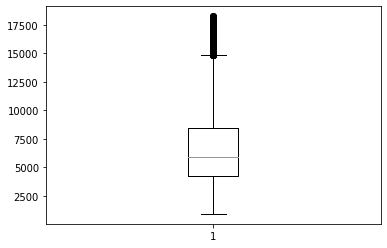

Current column: carat
count    83744.00
mean         1.07
std          0.18
min          0.81
25%          1.00
50%          1.01
75%          1.08
max          1.55
Name: carat, dtype: float64


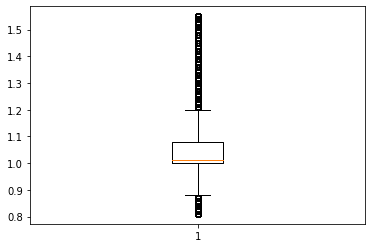

Current column: price_per_carat
count    83744.00
mean      6034.48
std       2330.19
min       1135.80
25%       4200.00
50%       5653.47
75%       7630.00
max      11866.67
Name: price_per_carat, dtype: float64


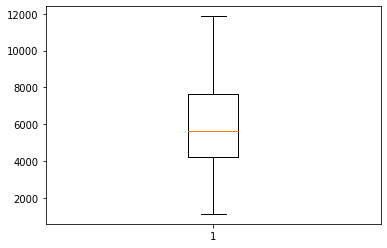

Current column: depth_perc
count    83744.00
mean        64.07
std          4.04
min         56.00
25%         62.00
50%         62.80
75%         64.50
max         78.00
Name: depth_perc, dtype: float64


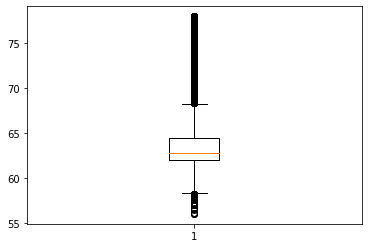

Current column: x
count    83744.00
mean         6.31
std          0.52
min          4.52
25%          6.15
50%          6.38
75%          6.51
max          7.62
Name: x, dtype: float64


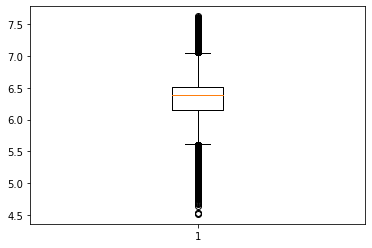

Current column: y
count    83744.00
mean         4.03
std          0.23
min          2.84
25%          3.90
50%          4.00
75%          4.07
max          4.80
Name: y, dtype: float64


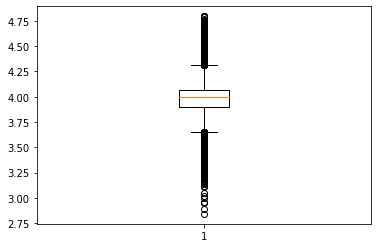

Current column: z
count    83744.00
mean         6.34
std          0.46
min          4.84
25%          6.15
50%          6.35
75%          6.50
max          8.46
Name: z, dtype: float64


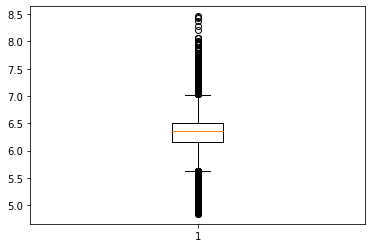

In [17]:
#Отрисуем визуализацию
check_df = df2.copy()
for x in ['price', 'carat', 'price_per_carat', 'depth_perc', 'x','y','z']:
  print('Current column:', x)
  print(check_df[x].describe().apply(lambda x: round(x,2)))
  plt.boxplot(check_df[x])
  plt.show()


In [18]:
#df_one = df.query('...') 
#df_three = df.query('...') 
# Посчитайте дстандартное отклонение по нескольким полям,
#  подумайте где оно должно равняться 0, а где меняться в каких-то разумных пределах

# Удалите аномальные наблюдения
#df_three = df_three.query('...').sort_values(by=['id','date'])

#df_three = df_three.groupby('...').agg('l...').reset_index() #тепреь в качестве цены возьмем последнее значение по времени

#df = pd.concat([df_one, df_three]).reset_index(drop=True) # соединяем результаты

In [19]:
#df2.hist(bins=50,figsize=(20,10))
#plt.show()

In [20]:
#sns.pairplot(df2, diag_kind = 'kde')

In [21]:
#plt.figure(figsize = (30,20))
#sns.heatmap(df3.corr(),annot = True , cmap = 'coolwarm' )

Видим корреляцию цены с размером камня и (ествественно) ценой за карат. чуть слабее крреляцию по размерам x,y,z.

Цены на бриллианты достаточно сильно меняются, попробуйте вычислить коэффициент инфляции и привести цены к последнему месяцу. Стоит учесть, что цены на все бриллианты не изменяются синхронно, то есть изменение в определенных группах может быть разным.

*Определите эти группы и рассчитайте коэффициенты инфляции для каждой из них. Подправьте цены на эти коэффициенты и создайте новую переменную.*

### Задание 2: Модель

Определите функцию потерь (MSE или MAE) и аргументируйте выбор.
Попробуйте сделать baseline.
Используйте LableEncoder для категориальных фичей и **постройте линейную модель**.

In [22]:
to_encode = ['fluor','symmetry',	'shape',	'color',	'clarity',	'polish', 'cut']

def encode_me(df2, to_encode):
  df3 = df2.copy()
  df3 = pd.get_dummies(data=df3, columns=to_encode)
  return df3

In [54]:
def get_inf(df3):
  categories = ['carat'] #определите по каким группам отпределять инфляцию (к примеру можно добавить каратную группу)

  df_index = df3.groupby(['date'] + categories)[['price_per_carat']]\
              .mean()\
              .reset_index() # индекс цен

  date_max = df_index.date.max()

  df_index = df_index.merge(df_index.query('date == @date_max')[categories + ['price_per_carat']]\
                            .rename(columns={'price_per_carat': 'price_per_carat_max'}), 
                            on=categories, how='outer') # сопоставляем группы с максимальной датой
  df_index
  df_index['inflation'] = df_index['price_per_carat_max'] / df_index.price_per_carat # вычисляем инфляцию

  df_with_inf = df3.merge(df_index[['date'] + categories + ['inflation']], 
                          on=['date'] + categories, how='left') # соединяем все в одной таблице

  df_with_inf = df_with_inf.dropna(subset=['inflation']).sort_values(by='inflation')#[df_with_inf['inflation']>=0]

  return df_with_inf
  #df_with_inf#[df_with_inf['id']==14652500]['inflation']

Теперь попробуйте OHE или TargetEncoder (сравните их).

Нормализуйте данные.

Поработайте с пропусками (обратите внимание на то, что у fluor возможен пропуск значения, а возможно отсутствие флуоресценции)

Покажите, насколько получилось улучшить результат.

In [24]:
def get_all_combs(ilist):
  combinations = list((itertools.product(ilist, repeat=len(ilist))))
  no_dups = set([tuple(set(x)) for x in combinations])
  return no_dups

In [63]:
import itertools

my_list = ['carat', 'price_per_carat', 'depth_perc', 'x','y','z']


def my_linear(dataset, comb_cols = my_list):
# Generate all possible combinations
  min_val = 1000
  min_comb = ['price', 'price_per_carat']
  r2 = .5

  combinations = get_all_combs(comb_cols)
  for comb in combinations:
    #dataset = get_inf(my_dataset)
    cols_to_drop=list(comb)+['price']

    y_valid, y_pred = my_model(dataset, cols_to_drop)

    r2_val = r2_score(y_valid, y_pred)  
    m = mean_absolute_error(y_valid, y_pred)

    if m < min_val and r2_val > r2:
      min_val = m
      min_comb = comb
      r2 = r2_val
      print("Mean squared error:", mean_squared_error(y_valid, y_pred))
      print("Mean absolute error:", mean_absolute_error(y_valid, y_pred))
      print("R-squared score:", r2_score(y_valid, y_pred))
      print()
  return(min_val, r2, min_comb, y_pred)
    
def my_model(dataset, cols_to_drop):
  X = dataset.drop(columns=cols_to_drop)
  y = dataset["price"]

  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)

  scaler = StandardScaler() # Помните, что на тесте делаем только transform
  X_train = scaler.fit_transform(X_train)
  X_valid = scaler.transform(X_valid)

  model_LR = LinearRegression()
  model_LR.fit(X_train, y_train)

  y_pred = model_LR.predict(X_valid)
  return y_valid, y_pred



Проверим разные комбинации чисельных признаков. Стоит отметить, что если бы мы не сделали обрезку выбросов по IQR*1.5 то модель была бы абсолютно бесполезна и предсказывала бы хуже чем r2=0.5

In [73]:
df4 = encode_me(df3, to_encode)
my_inf = get_inf(df4)
min_mae, min_r, min_col, y_pred = my_linear(my_inf)             
print(f'mae: {min_mae}\nr2: {min_r}\ncolumns to drop: {min_col}')


Mean squared error: 153829.2290886689
Mean absolute error: 261.83298194755184
R-squared score: 0.9839440936384485


Итак мы узнали, что на нашем датасете, наиболее точные предсказания дает регрессия, которая отбрасывает лишь столбец "z".

In [ ]:
df4 = encode_me(df3, to_encode)
my_inf = get_inf(df4)
y_valid, y_pred = my_model(my_inf, ['z','price'])
print("Mean squared error:", mean_squared_error(y_valid, y_pred))
print("Mean absolute error:", mean_absolute_error(y_valid, y_pred))
print("R-squared score:", r2_score(y_valid, y_pred))


Стоит отметить, что регрессия работала на обрезанном датасете - около 80к из 222222 значений
К тому же не проводился полный отсев по столбцам полученным через OHE, поскольку колаб крашится от перегруза в цикле с подбором лучше результата. 

In [215]:
from typing import Tuple, List


def OHE(df: pd.DataFrame, columns: List[str]) -> Tuple[pd.DataFrame, List[str]]:
    """
    Вместо это функции можно использовать и функционал pandas
    """
    index = df.index
    one = OneHotEncoder(sparse=False, categories='auto')
    ohe = one.fit_transform(df[columns])
    col_names = one.get_feature_names(input_features = columns)
    df = df.drop(columns, axis=1)
    df = df.reset_index(drop=True)
    df = pd.concat([df, pd.DataFrame(ohe, columns=col_names)], axis = 1)
    df = df.set_index(index)
    return (df, col_names)


In [228]:
min_com

('carat', 'carat', 'carat', 'carat', 'carat', 'y')

Сравните работу выбранной вами линейной модели с KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

...

## Классификация

Загрузите датасет bodyPerformance

Описание:

https://www.kaggle.com/datasets/kukuroo3/body-performance-data

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#path = 'drive/MyDrive/'

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Dimildizio/DS_course/main/shine-on-you/bodyPerformance.csv', index_col=0) #укажите свой путь

In [ ]:
df.head(20)

,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
age,,,,,,,,,,,
27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B
36.0,F,165.4,55.40,22.0,64.0,119.0,23.8,21.0,27.0,153.0,B
42.0,F,164.5,63.70,32.2,72.0,135.0,22.7,0.8,18.0,146.0,D
33.0,M,174.9,77.20,36.9,84.0,137.0,45.9,12.3,42.0,234.0,B
54.0,M,166.8,67.50,27.6,85.0,165.0,40.4,18.6,34.0,148.0,C


In [ ]:
df[df.duplicated()]

,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
age,,,,,,,,,,,
27.0,F,157.0,49.1,30.7,70.0,86.0,27.7,19.7,51.0,167.0,A


### Задание 1: Определение гендера

Постройте модель, которая будет определять гендер.

Для этого определите две метрики качества, на которые вы будете смотреть. Аргументируйте свой выбор.

После чего преобразуйте категориальные переменные и постройте модель бинарной классификации на основе линейного классификатора и сравните с KNN.

P.S.: не забудте про нормализацию.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X = df.drop(columns=["..."])
y = df["..."]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)

scaler = StandardScaler()

### Задание 2: Определение класса

Теперь опробуем построить модель, которая будет предсказывать class физической формы.

Для этого определите метрики качества для задачи мультиклассификации (аргументируйте выбор).

Постройте модель мультиклассовой классификации на основе линейного классификатора и сравните с KNN.

In [ ]:
X = df.drop(columns=["..."]) # укажите новый таргет
y = df["..."]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)

In [ ]:
...